In [1]:
#!pip install gensim

  Using cached gensim-4.2.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)
  Using cached smart_open-6.0.0-py3-none-any.whl (58 kB)


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import RNN, SimpleRNN, LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
import json

dataset= pd.read_csv(r'gs://tabular_bucket/ner_dataset.csv.temporary', encoding_errors='replace')
dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
dataset.columns= ['sentence', 'word', 'pos', 'tags']
dataset.head()

,sentence,word,pos,tags
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
dataset.shape

(145102, 4)

In [6]:
dataset.isnull().sum()

sentence    138490
word             0
pos              1
tags             1
dtype: int64

In [7]:
dataset['sentence']= dataset['sentence'].fillna(method= 'ffill')

In [8]:
dataset.head()

,sentence,word,pos,tags
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [9]:
dataset.dropna(inplace=True)
dataset.isnull().sum()

sentence    0
word        0
pos         0
tags        0
dtype: int64

In [10]:
sen_id= list(dataset['sentence'].unique())
print(len(sen_id))

6612


In [11]:
sent= []
pos= []
tags= []
for i in sen_id:
    sent.append(list(dataset[dataset.sentence == i]['word']))
    pos.append(list(dataset[dataset.sentence == i]['pos']))
    tags.append(list(dataset[dataset.sentence == i]['tags']))

In [12]:
print(sent[0])
print(pos[0])
print(tags[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [13]:
#Counting total number of words and tags
total_words= len(set(word.lower() for s in sent for word in s))
total_pos= len(set(parts_of_speech.lower() for p in pos for parts_of_speech in p))
total_tags= len(set(tag.lower() for t in tags for tag in t))
print("Total number of sentences: ", len(sent))
print("Total number of unique words: ", total_words)
print("Total number of unique pos: ", total_pos)
print("Total number of unique tags: ", total_tags)

Total number of sentences:  6612
Total number of unique words:  12173
Total number of unique pos:  41
Total number of unique tags:  17


In [14]:
#Tokenizing the text
word_tokenizer= Tokenizer()
word_tokenizer.fit_on_texts(sent)
X_encoded= word_tokenizer.texts_to_sequences(sent)

tag_tokenizer= Tokenizer()
tag_tokenizer.fit_on_texts(tags)
y_encoded= tag_tokenizer.texts_to_sequences(tags)

In [15]:
print(X_encoded[0])
print(y_encoded[0])

[230, 5, 948, 15, 1660, 251, 679, 6, 405, 1, 125, 4, 60, 8, 707, 1, 983, 5, 204, 123, 20, 14, 53, 2]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1]


In [16]:
#Check if any of the sentence and its corresponding tag output have different lengths
diff= [1 if len(ip) != len(op) else 0 for ip, op in zip(X_encoded, y_encoded)]
print(sum(diff))

0


In [17]:
# Pad sequences
lengths= [len(s) for s in X_encoded]
print("Largest sentence is of length: ", max(lengths))
print("Smallest sentence is of length: ", min(lengths))

Largest sentence is of length:  70
Smallest sentence is of length:  2


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


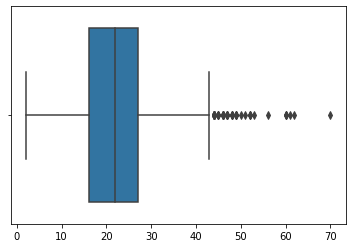

In [18]:
sns.boxplot(lengths)
plt.show()

In [19]:
#Truncating the sentences upto maximum length of 70 and padding the sequences.
max_seq_len= 70
X_padded= pad_sequences(X_encoded, maxlen= max_seq_len, padding='pre', truncating='post')
y_padded= pad_sequences(y_encoded, maxlen=max_seq_len, padding='pre', truncating='post')

In [20]:
print(X_padded[0], end='\n\n')
print(y_padded[0])
print()
print(X_padded[100], end='\n\n')
print(y_padded[100])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  230    5  948   15 1660  251  679    6  405    1
  125    4   60    8  707    1  983    5  204  123   20   14   53    2]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 6 1 1 1 1 1]

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  246   54  512   44  609    4 2439    6 2763  532  250    2]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 6 1 1 1 1 1 2 1 1 3 1 1]

In [21]:
X, y= X_padded, y_padded

In [22]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

/home/jupyter/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [23]:
#Word embeddings

word2vec= KeyedVectors.load_word2vec_format(path, binary=True)

In [24]:
#assigning word vectore from word2vec model
Embedding_size=300
Vocab_size= len(word_tokenizer.word_index)+1

#creating an empty word_embedding matrix
embedding_weights= np.zeros((Vocab_size, Embedding_size))

#creating word to index dictionary
word2idx= word_tokenizer.word_index

#Copy word vectors from word2vec model to the words present in the corpus
for word, index in word2idx.items():
    try:
        embedding_weights[index, :]= word2vec[word]
    except KeyError:
        pass

In [25]:
#Using OHE for output tags
Y= to_categorical(y)
Y.shape

(6612, 70, 18)

In [26]:
#Splitting the data in train, test and validation
Test_Size=0.15
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=Test_Size, random_state=42)

In [27]:
Val_Size=0.15
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=Val_Size, random_state=42)

In [28]:
print("TRAINING SET")
print(X_train.shape, y_train.shape)
print("*"*50)
print("VALIDATION SET")
print(X_val.shape, y_val.shape)
print("*"*50)
print("TEST SET")
print(X_test.shape, y_test.shape)

TRAINING SET
(4777, 70) (4777, 70, 18)
**************************************************
VALIDATION SET
(843, 70) (843, 70, 18)
**************************************************
TEST SET
(992, 70) (992, 70, 18)


In [29]:
Num_Classes= Y.shape[2]
Num_Classes

18

### LSTM Model

In [30]:
lstm_model= Sequential()
lstm_model.add(Embedding(input_dim= Vocab_size,
                       output_dim= Embedding_size,
                       input_length= max_seq_len,
                        weights= [embedding_weights],
                       trainable=True))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(Num_Classes, activation= 'softmax')))

2022-08-11 04:54:23.247377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 04:54:24.034248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 04:54:24.035084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 04:54:24.048843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [31]:
lstm_model.compile(loss= 'categorical_crossentropy',
                 optimizer= 'adam',
                 metrics= ['acc'])

In [32]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 300)           3652200   
                                                                 
 lstm (LSTM)                 (None, 70, 64)            93440     
                                                                 
 time_distributed (TimeDistr  (None, 70, 18)           1170      
 ibuted)                                                         
                                                                 
Total params: 3,746,810
Trainable params: 3,746,810
Non-trainable params: 0
_________________________________________________________________


In [33]:
lstm_training= lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


2022-08-11 04:55:39.170143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


38/38 [==============================] - 28s 25ms/step - loss: 1.3594 - acc: 0.9133 - val_loss: 0.3739 - val_acc: 0.9464
Epoch 2/10
38/38 [==============================] - 0s 9ms/step - loss: 0.3045 - acc: 0.9450 - val_loss: 0.2537 - val_acc: 0.9513
Epoch 3/10
38/38 [==============================] - 0s 10ms/step - loss: 0.2279 - acc: 0.9502 - val_loss: 0.2021 - val_acc: 0.9523
Epoch 4/10
38/38 [==============================] - 0s 10ms/step - loss: 0.1848 - acc: 0.9533 - val_loss: 0.1690 - val_acc: 0.9560
Epoch 5/10
38/38 [==============================] - 0s 9ms/step - loss: 0.1563 - acc: 0.9581 - val_loss: 0.1479 - val_acc: 0.9618
Epoch 6/10
38/38 [==============================] - 0s 10ms/step - loss: 0.1362 - acc: 0.9625 - val_loss: 0.1325 - val_acc: 0.9655
Epoch 7/10
38/38 [==============================] - 0s 10ms/step - loss: 0.1201 - acc: 0.9678 - val_loss: 0.1193 - val_acc: 0.9699
Epoch 8/10
38/38 [==============================] - 0s 10ms/step - loss: 0.1057 - acc: 0.9728 -

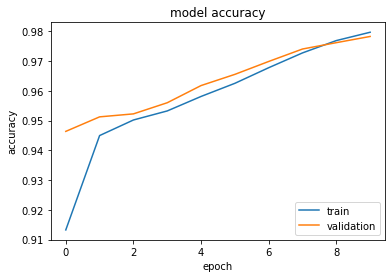

In [34]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

### Bi-LSTM Model

In [35]:
bi_lstm_model= Sequential()
bi_lstm_model.add(Embedding(input_dim= Vocab_size,
                       output_dim= Embedding_size,
                       input_length= max_seq_len,
                        weights= [embedding_weights],
                       trainable=True))
bi_lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bi_lstm_model.add(TimeDistributed(Dense(Num_Classes, activation= 'softmax')))

In [36]:
bi_lstm_model.compile(loss= 'categorical_crossentropy',
                 optimizer= 'adam',
                 metrics= ['acc'])

In [37]:
bi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 300)           3652200   
                                                                 
 bidirectional (Bidirectiona  (None, 70, 128)          186880    
 l)                                                              
                                                                 
 time_distributed_1 (TimeDis  (None, 70, 18)           2322      
 tributed)                                                       
                                                                 
Total params: 3,841,402
Trainable params: 3,841,402
Non-trainable params: 0
_________________________________________________________________


In [38]:
bi_lstm_training= bi_lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
38/38 [==============================] - 5s 40ms/step - loss: 1.1475 - acc: 0.9115 - val_loss: 0.2717 - val_acc: 0.9490
Epoch 2/10
38/38 [==============================] - 1s 15ms/step - loss: 0.2218 - acc: 0.9512 - val_loss: 0.1847 - val_acc: 0.9538
Epoch 3/10
38/38 [==============================] - 1s 14ms/step - loss: 0.1650 - acc: 0.9572 - val_loss: 0.1458 - val_acc: 0.9618
Epoch 4/10
38/38 [==============================] - 1s 14ms/step - loss: 0.1321 - acc: 0.9636 - val_loss: 0.1223 - val_acc: 0.9663
Epoch 5/10
38/38 [==============================] - 1s 14ms/step - loss: 0.1096 - acc: 0.9700 - val_loss: 0.1048 - val_acc: 0.9726
Epoch 6/10
38/38 [==============================] - 1s 14ms/step - loss: 0.0912 - acc: 0.9765 - val_loss: 0.0907 - val_acc: 0.9776
Epoch 7/10
38/38 [==============================] - 1s 15ms/step - loss: 0.0760 - acc: 0.9810 - val_loss: 0.0801 - val_acc: 0.9794
Epoch 8/10
38/38 [==============================] - 1s 16ms/step - loss: 0.0640 - a

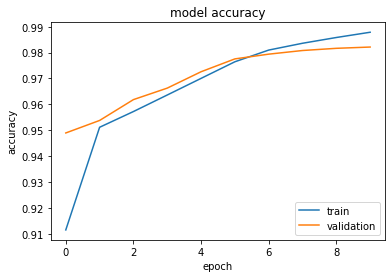

In [39]:
# visualise training history
plt.plot(bi_lstm_training.history['acc'])
plt.plot(bi_lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc="lower right")
plt.show()

### Evaluating the models

In [40]:
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

31/31 [==============================] - 0s 5ms/step - loss: 0.0941 - acc: 0.9764
Loss: 0.09411303699016571,
Accuracy: 0.9763824939727783


In [41]:
loss, accuracy = bi_lstm_model.evaluate(X_test, y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

31/31 [==============================] - 0s 7ms/step - loss: 0.0686 - acc: 0.9809
Loss: 0.06855715066194534,
Accuracy: 0.9809187650680542


### Bi-LSTM model performed better.